### Importing libraries & data.

In [2]:
import pandas as pd

from matplotlib import pyplot as plt
# from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde

from numpy.polynomial.chebyshev import Chebyshev
import numpy as np

from rich.console import Console
from rich.table import Table

from multiprocessing import Pool, cpu_count

import fastkde

import constants

### Importing data
data = pd.read_csv("data/fsigma8_data.dat", sep=';', header=0)
z_data = data['z']
fs8_data = data['fsig8']
fs8_err_plus = data['fsig8_err_plus']
fs8_err_minus = data['fsig8_err_minus']
fs8_err = [fs8_err_plus, fs8_err_minus]

### Defining functions (vectorized).

In [58]:
def omega_m(z, omega_0):
    z = np.asarray(z)
    omega_0 = np.asarray(omega_0)
    return omega_0 * (1 + z)**3 / (omega_0 * (1 + z)**3 + 1 - omega_0)

def g(z, omega_0, omega_l0=0.7):
    omz = omega_m(z, omega_0)
    olz = 1 - omz
    return 2.5 * omz / (omz**(4/7) - olz + (1 + omz/2)*(1 + olz/70))

def D(z, omega_0, omega_l0=0.7):
    return g(z, omega_0, omega_l0) / g(0, omega_0, omega_l0) / (1 + np.asarray(z))

def gamma(omega_m_z):
    omega_m_z = np.asarray(omega_m_z)
    return 6/11 - 15/2057 * np.log(omega_m_z)

def sigma_8(z, omega_0, sigma_8_0):
    return sigma_8_0 * D(z, omega_0)

def f(gamma_func, z, omega_0):
    omega_m_z = omega_m(z, omega_0)
    return omega_m_z ** gamma_func(omega_m_z)

def growth(z, gamma_func = gamma, omega_0 = constants.OMEGA_0, sigma_8_0 = constants.SIGMA_8_0):
    """Returns linear growth rate according to the redshift.

    Args:
        z (float): redshift
        fun_gamma (γ): gamma. Defaults to gamma.
        omega_0 (float): Ωm(0). Defaults to constants.OMEGA_0.
        sigma_8_0 (float): σ8(0). Defaults to constants.SIGMA_8_0.

    Returns:
        float: fσ8(z)
    """
    return f(gamma_func, z, omega_0) * sigma_8(z, omega_0, sigma_8_0)

def display(res, title):
    """Displays results as a table. 

    Args:
        res (table): [t1, t2, ...] with ti = [name, value, error]
        title (str): table title
    """
    console = Console()
    table = Table(title=title)

    table.add_column("Variable name", justify="center")
    table.add_column("Value", justify="center")
    table.add_column("Error", justify="center")

    for row in res:
        table.add_row(row[0], f"{row[1]:.3f}", "-" if row[2]=="-" else f"{row[2]:.3f}")
        
    console.print(table)

def display_plot(PDF, x_mean_std, y_mean_std, ax1_label, ax2_label, ax):
    """_summary_

    Args:
        PDF (_type_): _description_
        x_mean_std (_type_): _description_
        y_mean_std (_type_): _description_
        ax1_label (_type_): _description_
        ax2_label (_type_): _description_
        ax (_type_): _description_
    """
    x_grid = PDF.coords[PDF.dims[1]].values
    y_grid = PDF.coords[PDF.dims[0]].values
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')
    Z = PDF.values

    contour = ax.contourf(X, Y, Z, levels=30, cmap='inferno')
    plt.colorbar(contour, ax=ax)


    x_mean, x_std = x_mean_std
    y_mean, y_std = y_mean_std
    ax.plot(x_mean, y_mean, 'ko', label='Best-fit')
    ax.axhline(y_mean, color='indigo', linestyle='--')
    ax.axvline(x_mean, color='indigo', linestyle='--')

    ax.set_xlabel(ax1_label, fontsize=14)
    ax.set_ylabel(ax2_label, fontsize=14)
    ax.set_title(f"PDF({ax1_label}, {ax2_label})", fontsize=12)

### Plotting distribution

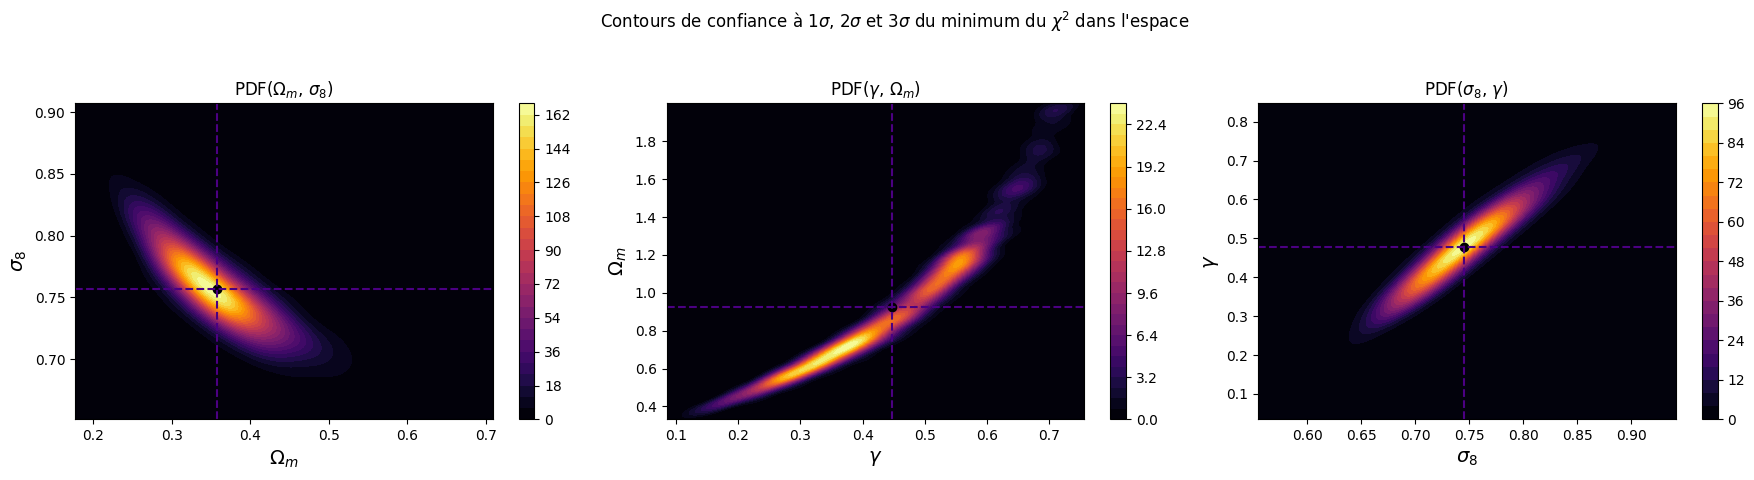

     Results for (Ωₘ, σ8) :      
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│  $\sigma_8$   │ 0.358 │ 0.060 │
│      Ωₘ       │ 0.757 │ 0.032 │
└───────────────┴───────┴───────┘

      Results for (γ, Ωₘ) :      
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│  $\Omega_m$   │ 0.448 │ 0.129 │
│    \gamma     │ 0.925 │ 0.330 │
└───────────────┴───────┴───────┘

      Results for (σ8, γ) :      
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│  $\sigma_8$   │ 0.745 │ 0.047 │
│    \gamma     │ 0.479 │ 0.105 │
└───────────────┴───────┴───────┘

In [61]:
def make_constant_gamma_func(gamma_value):
    return lambda omega_m_z: gamma_value

def calc_chi2_gamma_sigma(sigma_8, gamma_value):
    gamma_func = make_constant_gamma_func(gamma_value)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    chi2 = np.sum((growth(z_data.values, gamma_func, sigma_8_0 = sigma_8) - fs8_data)**2 / errors**2)
    return chi2

def calc_chi2_gamma_omega(omega_0, gamma_value):
    gamma_func = make_constant_gamma_func(gamma_value)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    chi2 = np.sum((growth(z_data.values, gamma_func, omega_0) - fs8_data)**2 / errors**2)
    return chi2

def calc_chi2_sigma_omega_vectorized(omega0, sigma8_0):
    omega0 = np.asarray(omega0)
    sigma8_0 = np.asarray(sigma8_0)
    errors = 0.5 * (fs8_err_plus + fs8_err_minus)
    
    model = growth(z_data.values, omega_0=omega0[..., None], sigma_8_0=sigma8_0[..., None])
    residuals = (model - fs8_data) / errors
    chi2 = np.sum(residuals**2)
    return chi2

def mcmc_metropolis_hastings(n_steps, initial_params, initial_params_intervals, proposal_widths, calc_chi2_func):
    current_param1, current_param2 = initial_params
    interval_param1_1, interval_param1_2 = initial_params_intervals[0]
    interval_param2_1, interval_param2_2 = initial_params_intervals[1]
    chain = np.zeros((n_steps, 2))
    current_chi2 = calc_chi2_func(current_param1, current_param2)
    
    for i in range(n_steps):
        proposed_param1 = np.random.normal(current_param1, proposal_widths[0])
        proposed_param2 = np.random.normal(current_param2, proposal_widths[1])
        
        # Physical constraints
        if not (interval_param1_1 < proposed_param1 < interval_param1_2 and interval_param2_1 < proposed_param2 < interval_param2_2):
            chain[i] = [current_param1, current_param2]
            continue
        
        proposed_chi2 = calc_chi2_func(proposed_param1, proposed_param2)
        
        delta_chi2 = proposed_chi2 - current_chi2
        acceptance_prob = np.exp(-0.5 * delta_chi2)
        
        if np.random.rand() < acceptance_prob:
            current_param1, current_param2 = proposed_param1, proposed_param2
            current_chi2 = proposed_chi2
        
        chain[i] = [current_param1, current_param2]
    
    return chain

def run_single_chain(seed, initial_value1, initial_value2, initial_params_intervals, calc_chi2_func):
    np.random.seed(seed)
    return mcmc_metropolis_hastings(
        n_steps=n_steps // n_chains,
        initial_params=[initial_value1 + 0.01*np.random.randn(), initial_value2 + 0.01*np.random.randn()],
        initial_params_intervals=initial_params_intervals,
        proposal_widths=proposal_widths,
        calc_chi2_func=calc_chi2_func
    )

def run_single_chain_gamma_sigma(seed):
    return run_single_chain(seed, initial_value1=0.81, initial_value2=0.55, initial_params_intervals=[[0, 2], [0, 2]], calc_chi2_func=calc_chi2_gamma_sigma)


def run_single_chain_gamma_omega(seed):
    return run_single_chain(seed, initial_value1=0.3, initial_value2=0.55, initial_params_intervals=[[0, 1], [0, 2]], calc_chi2_func=calc_chi2_gamma_omega)


def run_single_chain_sigma_omega(seed):
    return run_single_chain(seed, initial_value1=0.3, initial_value2=0.81, initial_params_intervals=[[0, 1], [0, 2]], calc_chi2_func=calc_chi2_sigma_omega_vectorized)


def run_chain(chain_func, var_names):
    n_chains = min(cpu_count(), 8)
    burn_in = 1000

    with Pool(n_chains) as pool:
        chains = pool.map(chain_func, range(n_chains))

    chain_all = np.vstack(chains)
    chain_clean = chain_all[burn_in:]

    x = chain_clean[:, 0]
    y = chain_clean[:, 1]

    PDF = fastkde.pdf(x, y, var_names=var_names, num_points=2**10 + 1)

    x_mean_std, y_mean_std = [np.mean(x), np.std(x)], [np.mean(y), np.std(y)]
    return PDF, x_mean_std, y_mean_std

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"Contours de confiance à 1$\sigma$, 2$\sigma$ et 3$\sigma$ du minimum du $\chi^2$ dans l'espace")

PDF1, x_mean_std1, y_mean_std1 = run_chain(run_single_chain_sigma_omega, ['sigma', 'omega'])
display_plot(PDF1, x_mean_std1, y_mean_std1, r"$\Omega_m$", r"$\sigma_8$", axes[0])

PDF2, x_mean_std2, y_mean_std2 = run_chain(run_single_chain_gamma_omega, ['omega', 'gamma'])
display_plot(PDF2, x_mean_std2, y_mean_std2, r"$\gamma$", r"$\Omega_m$", axes[1])

PDF3, x_mean_std3, y_mean_std3 = run_chain(run_single_chain_gamma_sigma, ['gamma', 'sigma'])
display_plot(PDF3, x_mean_std3, y_mean_std3, r"$\sigma_8$", r"$\gamma$", axes[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Display tables of results
display([[r"$\sigma_8$"] + x_mean_std1, ["Ωₘ"] + y_mean_std1], "Results for (Ωₘ, σ8) :")
display([[r"$\Omega_m$"] + x_mean_std2, [r"\gamma"] + y_mean_std2], "Results for (γ, Ωₘ) :")
display([[r"$\sigma_8$"] + x_mean_std3, [r"\gamma"] + y_mean_std3], "Results for (σ8, γ) :")


             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      σ8       │ 0.745 │ 0.047 │
│       γ       │ 0.479 │ 0.105 │
└───────────────┴───────┴───────┘

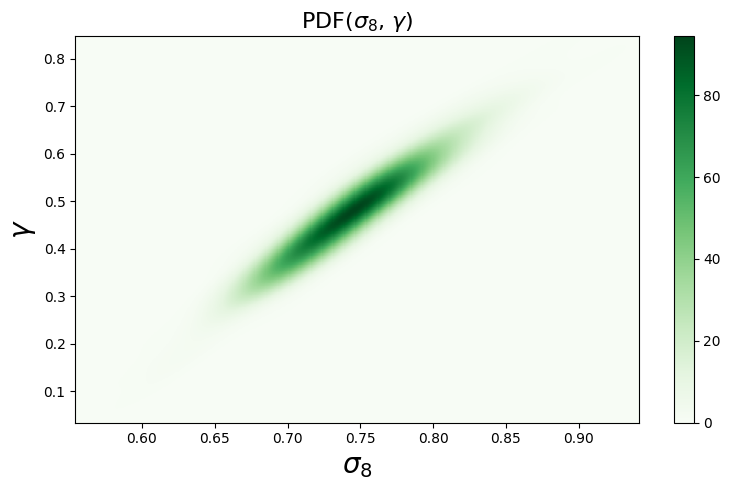

In [5]:

n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_gamma_sigma, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

x = chain_clean[:, 0]
y = chain_clean[:, 1]

xmin, xmax = 0.1, 0.8
ymin, ymax = 0.25, 2.0

PDF = fastkde.pdf(x, y, var_names=['Omega_m', 'gamma'], num_points=2**10 + 1)
X, Y = np.meshgrid(PDF['Omega_m'].values, PDF['gamma'].values, indexing='xy')
Z = PDF.values 

sigma_8_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

results = [["σ8", sigma_8_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)

display_plot(PDF, r"$\sigma_8$", r"$\gamma$")

             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.358 │ 0.060 │
│    sigma8     │ 0.757 │ 0.032 │
└───────────────┴───────┴───────┘

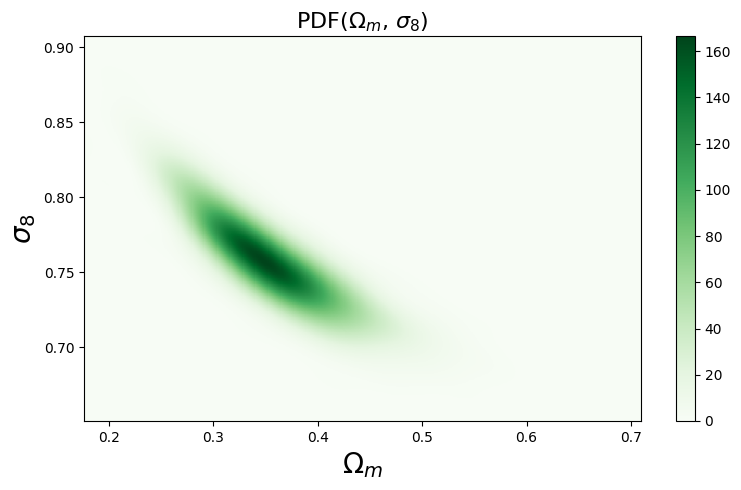

In [6]:
n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_sigma_omega, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

omega_m_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

x = chain_clean[:, 0]
y = chain_clean[:, 1]

xmin, xmax = 0.1, 0.8
ymin, ymax = 0.25, 2.0

PDF = fastkde.pdf(x, y, var_names=['sigma_8', 'gamma'], num_points=2**10 + 1)
X, Y = np.meshgrid(PDF['sigma_8'].values, PDF['gamma'].values, indexing='xy')
Z = PDF.values 

sigma_8_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

results = [["Ωₘ", sigma_8_mean, np.std(chain_clean[:, 0])], 
           ["sigma8", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)

display_plot(PDF, r"$\Omega_m$", r"$\sigma_8$")


             Results             
┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Variable name ┃ Value ┃ Error ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│      Ωₘ       │ 0.448 │ 0.129 │
│       γ       │ 0.925 │ 0.330 │
└───────────────┴───────┴───────┘

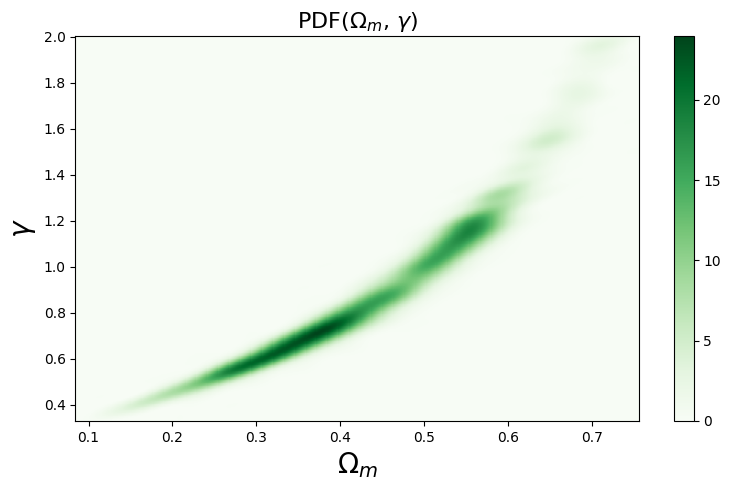

In [12]:
n_steps = 10000 * 10
n_chains = min(cpu_count(), 8)
proposal_widths = [0.02, 0.01]

# Parallelization
with Pool(n_chains) as pool:
    chains = pool.map(run_single_chain_gamma_omega, range(n_chains))

chain_all = np.vstack(chains)
burn_in = 1000
chain_clean = chain_all[burn_in:]

omega_m_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

x = chain_clean[:, 0]
y = chain_clean[:, 1]

xmin, xmax = 0.1, 0.8
ymin, ymax = 0.25, 2.0

PDF = fastkde.pdf(x, y, var_names=['omega', 'gamma'], num_points=2**10 + 1)
X, Y = np.meshgrid(PDF['omega'].values, PDF['gamma'].values, indexing='xy')
Z = PDF.values 

omega_m_mean = np.mean(chain_clean[:, 0])
gamma_mean = np.mean(chain_clean[:, 1])

results = [["Ωₘ", omega_m_mean, np.std(chain_clean[:, 0])], 
           ["γ", gamma_mean, np.std(chain_clean[:, 1])]]
display(results)

display_plot(PDF, r"$\Omega_m$", r"$\gamma$")
